In [51]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime, timedelta
from time import sleep

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

from TicTacToe import TicTacToe

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

## Часть первая: крестики-нолики при помощи Q-обучения

In [2]:
def get_move(env, pi, s, actions, eps):
    '''Делаем ход по стратегии пи'''

    if np.random.rand() < eps:
        action = actions[np.random.choice(len(actions))]
        action_ind = env.int_from_action(action)
    elif (pi is not None) and (s in pi):
        action_ind = pi[s]
    else:
        action = actions[np.random.choice(len(actions))]
        action_ind = env.int_from_action(action)
    return action_ind


def run_episode(env, pi1=None, pi2=None, eps1=0, eps2=0):
    '''Играем тестовую партию между стратегиями'''

    env.reset()
    states, actions = [env.getState()], []

    done = False

    while not done:
        # s, available_actions = env.getHash(), env.getEmptySpaces()
        state_hash, available_actions, cur_turn = env.getState()

        if cur_turn == 1:
            action_ind = get_move(env, pi1, state_hash, available_actions, eps1)
        else:
            action_ind = get_move(env, pi2, state_hash, available_actions, eps2)
        
        observation, reward, done, info = env.step(env.action_from_int(action_ind))
        states.append(observation)
        actions.append(action_ind)         

    return states, reward, actions
    

def run_experiments(env, pi1=None, pi2=None, num_experiments=100000):
    '''Играем серию партий между стратегиями и оцениваем среднюю награду и число шагов'''

    num_steps, total_reward = np.array([0.0] * num_experiments), np.array([0.0] * num_experiments)

    for i in range(num_experiments):
        states, reward, _ = run_episode(env, pi1, pi2)
        num_steps[i] = len(states) - 1
        total_reward[i] = reward

    mean_reward = np.mean(total_reward)
    mean_num_steps = np.mean(num_steps)

    print("Средняя награда: %.6f\nСреднее число шагов: %.6f\n" % \
        (mean_reward, mean_num_steps))

    return mean_reward, mean_num_steps

Проверим как случайные стратегии играют друг с другом и заодно проверим окружение

In [115]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
run_experiments(env, None, None, 10000);

Средняя награда: 0.293900
Среднее число шагов: 7.643300



In [116]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
run_episode(env, None, None)
env.render()

-------------
| x | x | x | 
-------------
| x | o | o | 
-------------
|   |   | o | 
-------------


Реализуем 2 стратегии для крестиков и ноликов с помощью Q-обучения. В качестве оценки качества будем смотреть среднюю награду игрока за крестики в матчах между: обучаемыми стратегиями, обучаемой стратегии крестиков против случайной ноликов и обучаемой стратегии ноликов против случайной крестиков.

In [3]:
def update_returns_actions(pi1, pi2, Q1, Q2, states, reward, actions):
    stop1 = False
    stop2 = False
    for i in range(len(states) - 2, -1, -1):
        state = states[i]

        if state[2] == 1 and not stop1:
            try:
                mean, n = Q1[state[0]][actions[i]]
                Q1[state[0]][actions[i]] = ((mean * n + reward) / (n + 1), n + 1)
            except:
                Q1[state[0]] = {env.int_from_action(action): (0, 0) for action in state[1]}
                Q1[state[0]][actions[i]] = (reward, 1)
        
            actions_reward = np.array([ action[0] for action in Q1[state[0]].values() ])     
            true_move = [*Q1[state[0]].keys()][np.argmax(actions_reward)]
            pi1[state[0]] = true_move
            if not (true_move == actions[i]):
                stop1 = True

        elif state[2] == -1 and not stop2:
            try:
                mean, n = Q2[state[0]][actions[i]]
                Q2[state[0]][actions[i]] = ((mean * n + reward) / (n + 1), n + 1)
            except:
                Q2[state[0]] = {env.int_from_action(action): (0, 0) for action in state[1]}
                Q2[state[0]][actions[i]] = (reward, 1)
        
            actions_reward = np.array([ action[0] for action in Q2[state[0]].values() ]) 
            true_move = [*Q2[state[0]].keys()][np.argmin(actions_reward)]
            pi2[state[0]] = true_move
            if not (true_move == actions[i]):
                stop2 = True

        else:
            break


In [4]:
def fit(env, step_episodes=256, max_do_not_imp_rounds=4, valid_exp=10000, eps1=0.2, eps2=0.2):
    Q1 = {}
    Q2 = {}
    pi1 = {}
    pi2 = {}

    i = 1
    do_not_imp_rounds = 0

    episodes = [0]
    mean_rewards, mean_num_steps = [0], [0]
    mean_rewards1, mean_num_steps1 = [0], [0]
    mean_rewards2, mean_num_steps2 = [0], [0]

    print("episod: 0\n\nX vs O:")
    mean_rewards[0], mean_num_steps[0] = run_experiments(env, pi1, pi2, valid_exp)
    mean_rewards1[0], mean_num_steps1[0] = mean_rewards[0], mean_num_steps[0]
    mean_rewards2[0], mean_num_steps2[0] = mean_rewards[0], mean_num_steps[0]

    best_reward1 = mean_rewards1[0]
    best_reward2 = mean_rewards2[0]

    while True:
        states, reward, actions = run_episode(env, pi1, pi2, eps1, eps2)
        update_returns_actions(pi1, pi2, Q1, Q2, states, reward, actions)
        

        if i % step_episodes == 0:
            print(f"episod: {i}\n")
            episodes.append(i)

            print("X vs random O:")
            mean_r1, mean_n_s1 = run_experiments(env, pi1, None, valid_exp)
            mean_rewards1.append(mean_r1)
            mean_num_steps1.append(mean_n_s1)

            print("O vs random X:")
            mean_r2, mean_n_s2 = run_experiments(env, None, pi2, valid_exp)
            mean_rewards2.append(mean_r2)
            mean_num_steps2.append(mean_n_s2)

            print("X vs O:")
            mean_r, mean_n_s = run_experiments(env, pi1, pi2, valid_exp)
            mean_rewards.append(mean_r)
            mean_num_steps.append(mean_n_s)

            if mean_rewards1[-1] > best_reward1:
                best_reward1 = mean_rewards1[-1]
                do_not_imp_rounds = 0
            if mean_rewards2[-1] < best_reward2:
                best_reward2 = mean_rewards2[-1]
                do_not_imp_rounds = 0
            else:
                do_not_imp_rounds += 1
                if do_not_imp_rounds >= max_do_not_imp_rounds:
                    break

        i += 1
    
    data = {
        "episodes": episodes,
        "X": (mean_rewards1, mean_num_steps1),
        "O": (mean_rewards2, mean_num_steps2),
        "XO": (mean_rewards, mean_num_steps),
    }

    return pi1, pi2, data

In [5]:
def plot_results(data, title):
    episodes = data["episodes"]
    mean_rewards1, mean_num_steps1 = data["X"]
    mean_rewards2, mean_num_steps2 = data["O"]
    mean_rewards, mean_num_steps = data["XO"]

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax2 = ax.twinx()
    ax2.grid(None)

    line1 = ax.plot(episodes, mean_rewards1, label="Средние награды X vs rO", color="C0")
    line2 = ax2.plot(episodes, mean_num_steps1, label="Среднее число шагов X vs rO", color="C1")

    line3 = ax.plot(episodes, mean_rewards2, label="Средние награды rX vs O", color="C3")
    line4 = ax2.plot(episodes, mean_num_steps2, label="Среднее число шагов rX vs O", color="C4")

    line5 = ax.plot(episodes, mean_rewards, label="Средние награды X vs O", color="C5")
    line6 = ax2.plot(episodes, mean_num_steps, label="Среднее число шагов X vs O", color="C6")

    lines = line1 + line2 + line3 + line4 + line5 + line6
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc=2)
    ax.set_xlim((episodes[0], episodes[-1]))
    ax.set_title(title, fontdict={'fontsize': 20})
    return fig, ax

In [126]:
env = TicTacToe(3, 3, 3)
step_episodes = 512
max_do_not_imp_rounds = 4
valid_exp = 5000
eps1 = 0.2
eps2 = 0.2

pi1, pi2, data = fit(env, step_episodes, max_do_not_imp_rounds, valid_exp, eps1, eps2)

episod: 0

X vs O:
Средняя награда: 0.311200
Среднее число шагов: 7.602600

episod: 512

X vs random O:
Средняя награда: 0.605600
Среднее число шагов: 6.525400

O vs random X:
Средняя награда: 0.164800
Среднее число шагов: 7.643200

X vs O:
Средняя награда: -0.043800
Среднее число шагов: 8.083200

episod: 1024

X vs random O:
Средняя награда: 0.853000
Среднее число шагов: 5.892200

O vs random X:
Средняя награда: 0.026600
Среднее число шагов: 7.504600

X vs O:
Средняя награда: 0.000000
Среднее число шагов: 9.000000

episod: 1536

X vs random O:
Средняя награда: 0.611400
Среднее число шагов: 7.123600

O vs random X:
Средняя награда: -0.148600
Среднее число шагов: 7.371400

X vs O:
Средняя награда: 1.000000
Среднее число шагов: 9.000000

episod: 2048

X vs random O:
Средняя награда: 0.732400
Среднее число шагов: 6.504600

O vs random X:
Средняя награда: -0.187400
Среднее число шагов: 7.304800

X vs O:
Средняя награда: 0.000000
Среднее число шагов: 9.000000

episod: 2560

X vs random O:
С

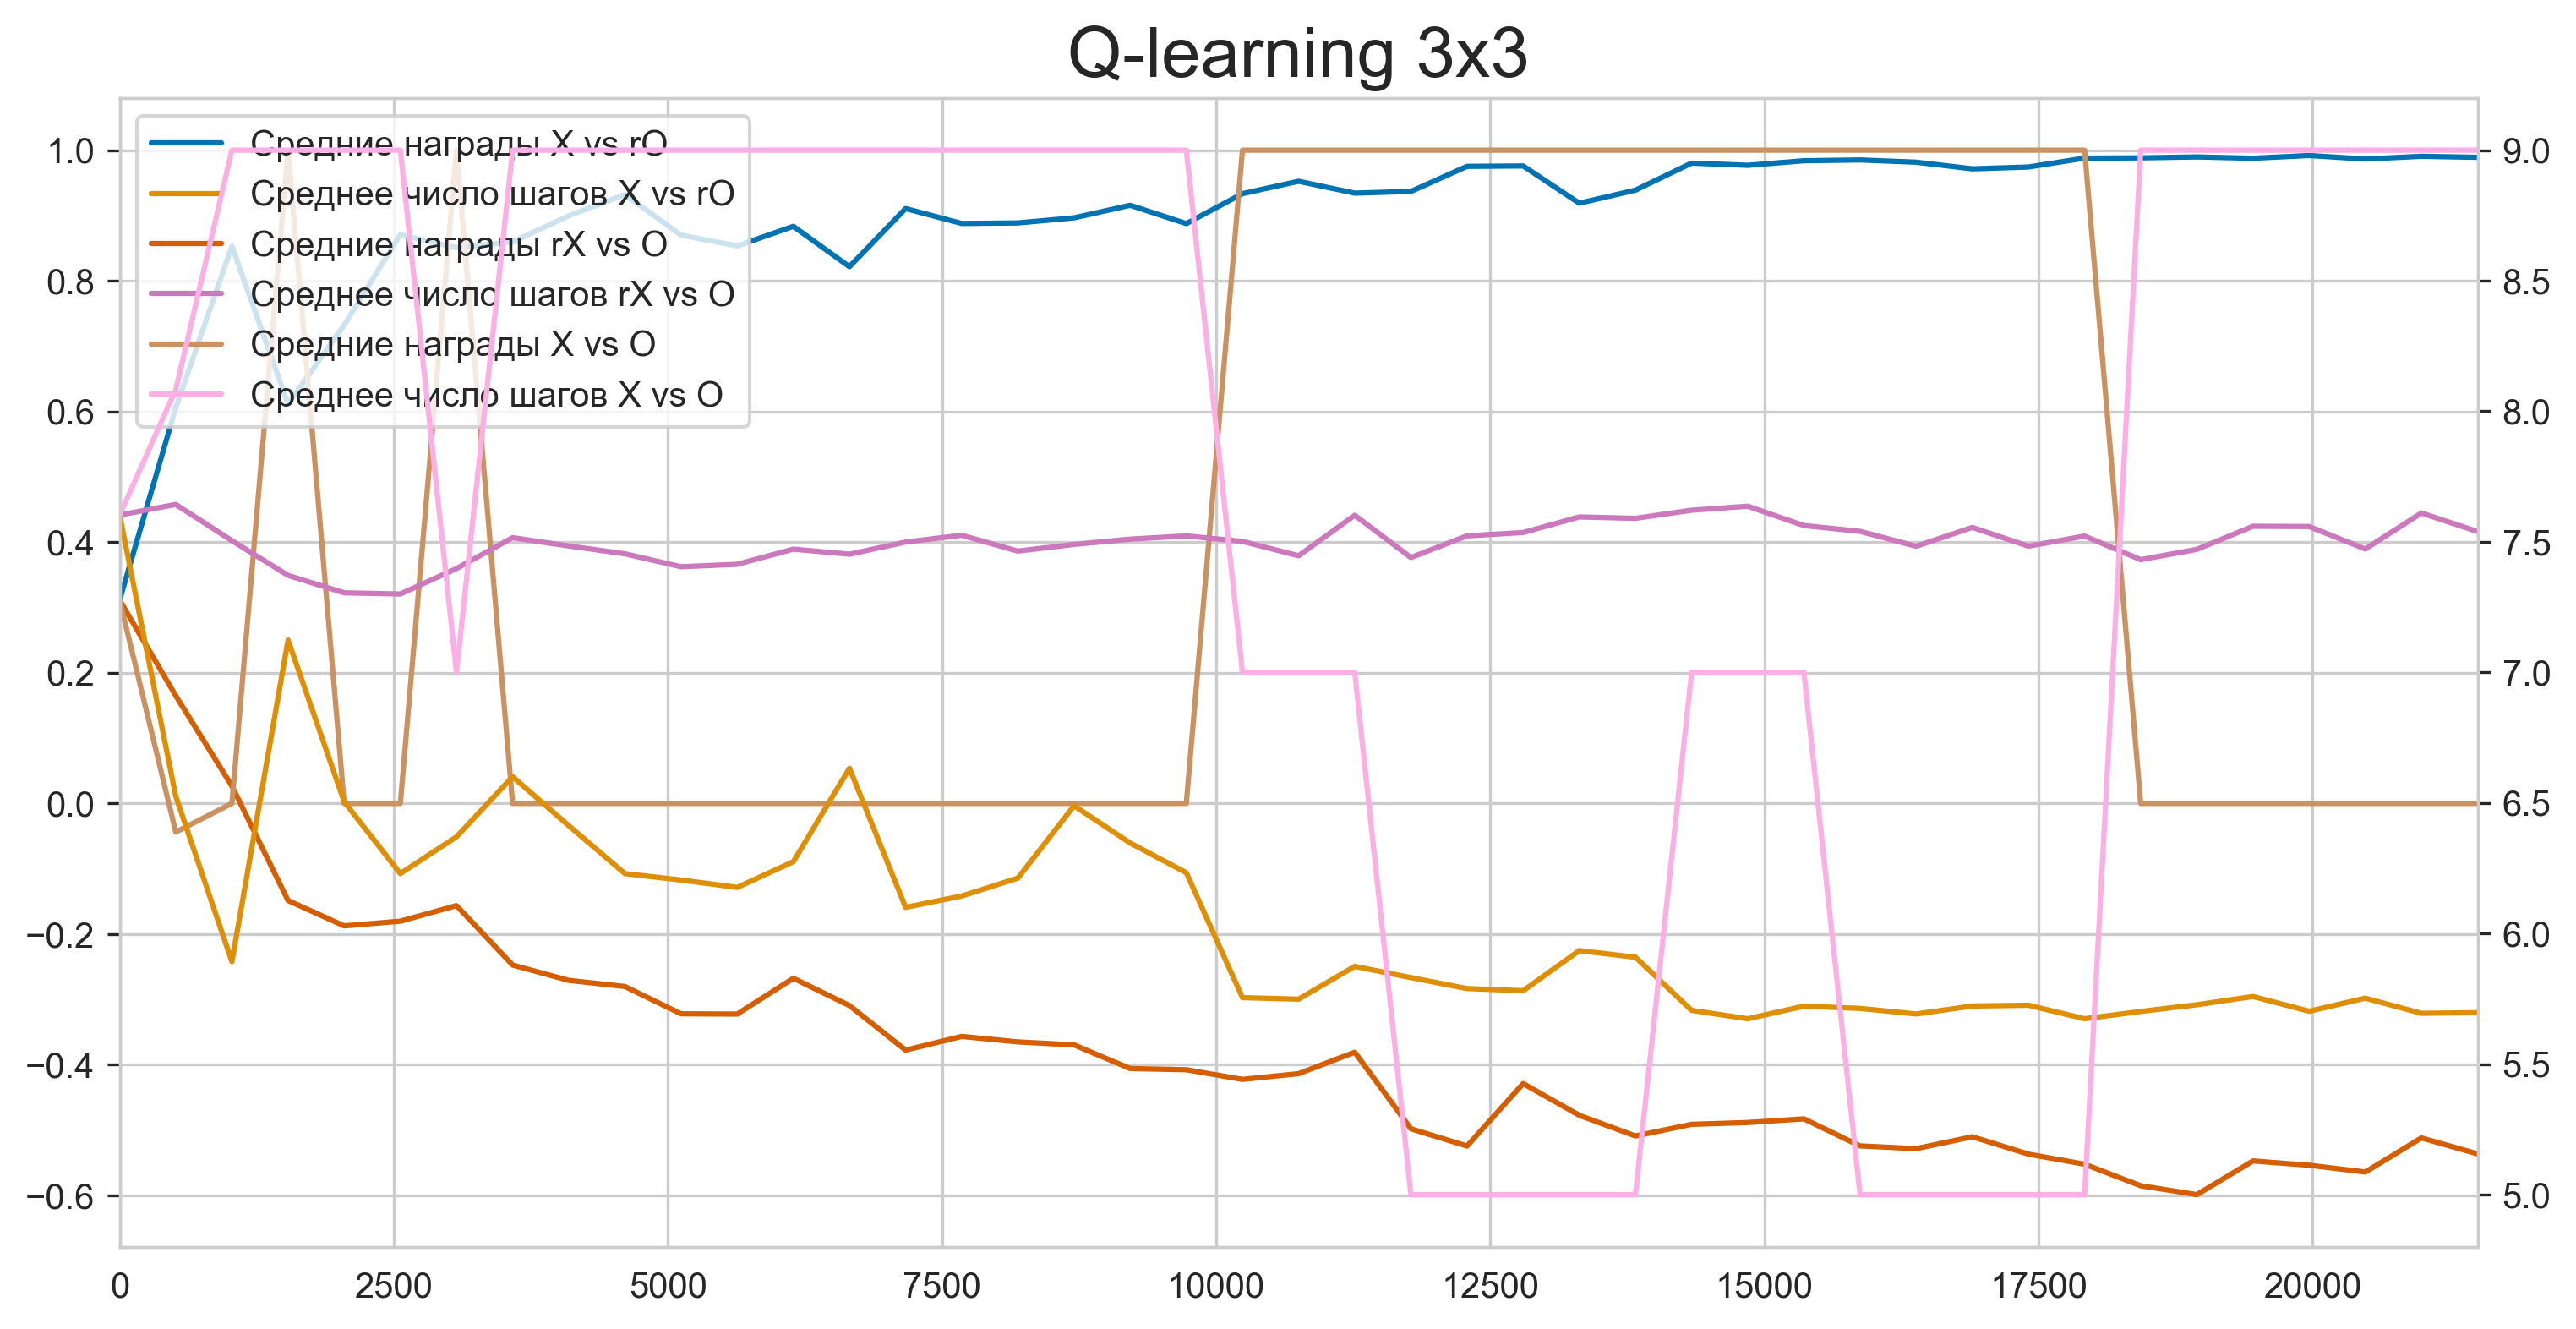

In [127]:
title = "Q-learning 3x3"
plot_results(data, title);

В результате получим, что при хорошей игре обоих игроков всегда будет ничья и будет заполнено все поле, однако если хоть один из них не умеет хорошо играть, то шанс на победу выше у более опытного игрока.  

Проверим это для окружения 4х4х4

In [134]:
env = TicTacToe(4, 4, 4)
step_episodes = 20000
max_do_not_imp_rounds = 4
valid_exp = 5000
eps1 = 0.2
eps2 = 0.2

pi1, pi2, data = fit(env, step_episodes, max_do_not_imp_rounds, valid_exp, eps1, eps2)

episod: 0

X vs O:
Средняя награда: 0.059600
Среднее число шагов: 14.512000

episod: 20000

X vs random O:
Средняя награда: 0.073000
Среднее число шагов: 14.506600

O vs random X:
Средняя награда: 0.034200
Среднее число шагов: 14.512400

X vs O:
Средняя награда: 0.079600
Среднее число шагов: 14.499000

episod: 40000

X vs random O:
Средняя награда: 0.084200
Среднее число шагов: 14.464200

O vs random X:
Средняя награда: 0.039200
Среднее число шагов: 14.569000

X vs O:
Средняя награда: 0.067200
Среднее число шагов: 14.531200

episod: 60000

X vs random O:
Средняя награда: 0.088000
Среднее число шагов: 14.463000

O vs random X:
Средняя награда: 0.031400
Среднее число шагов: 14.492600

X vs O:
Средняя награда: 0.067000
Среднее число шагов: 14.488200

episod: 80000

X vs random O:
Средняя награда: 0.108000
Среднее число шагов: 14.388600

O vs random X:
Средняя награда: 0.050800
Среднее число шагов: 14.531800

X vs O:
Средняя награда: 0.064800
Среднее число шагов: 14.460600

episod: 100000


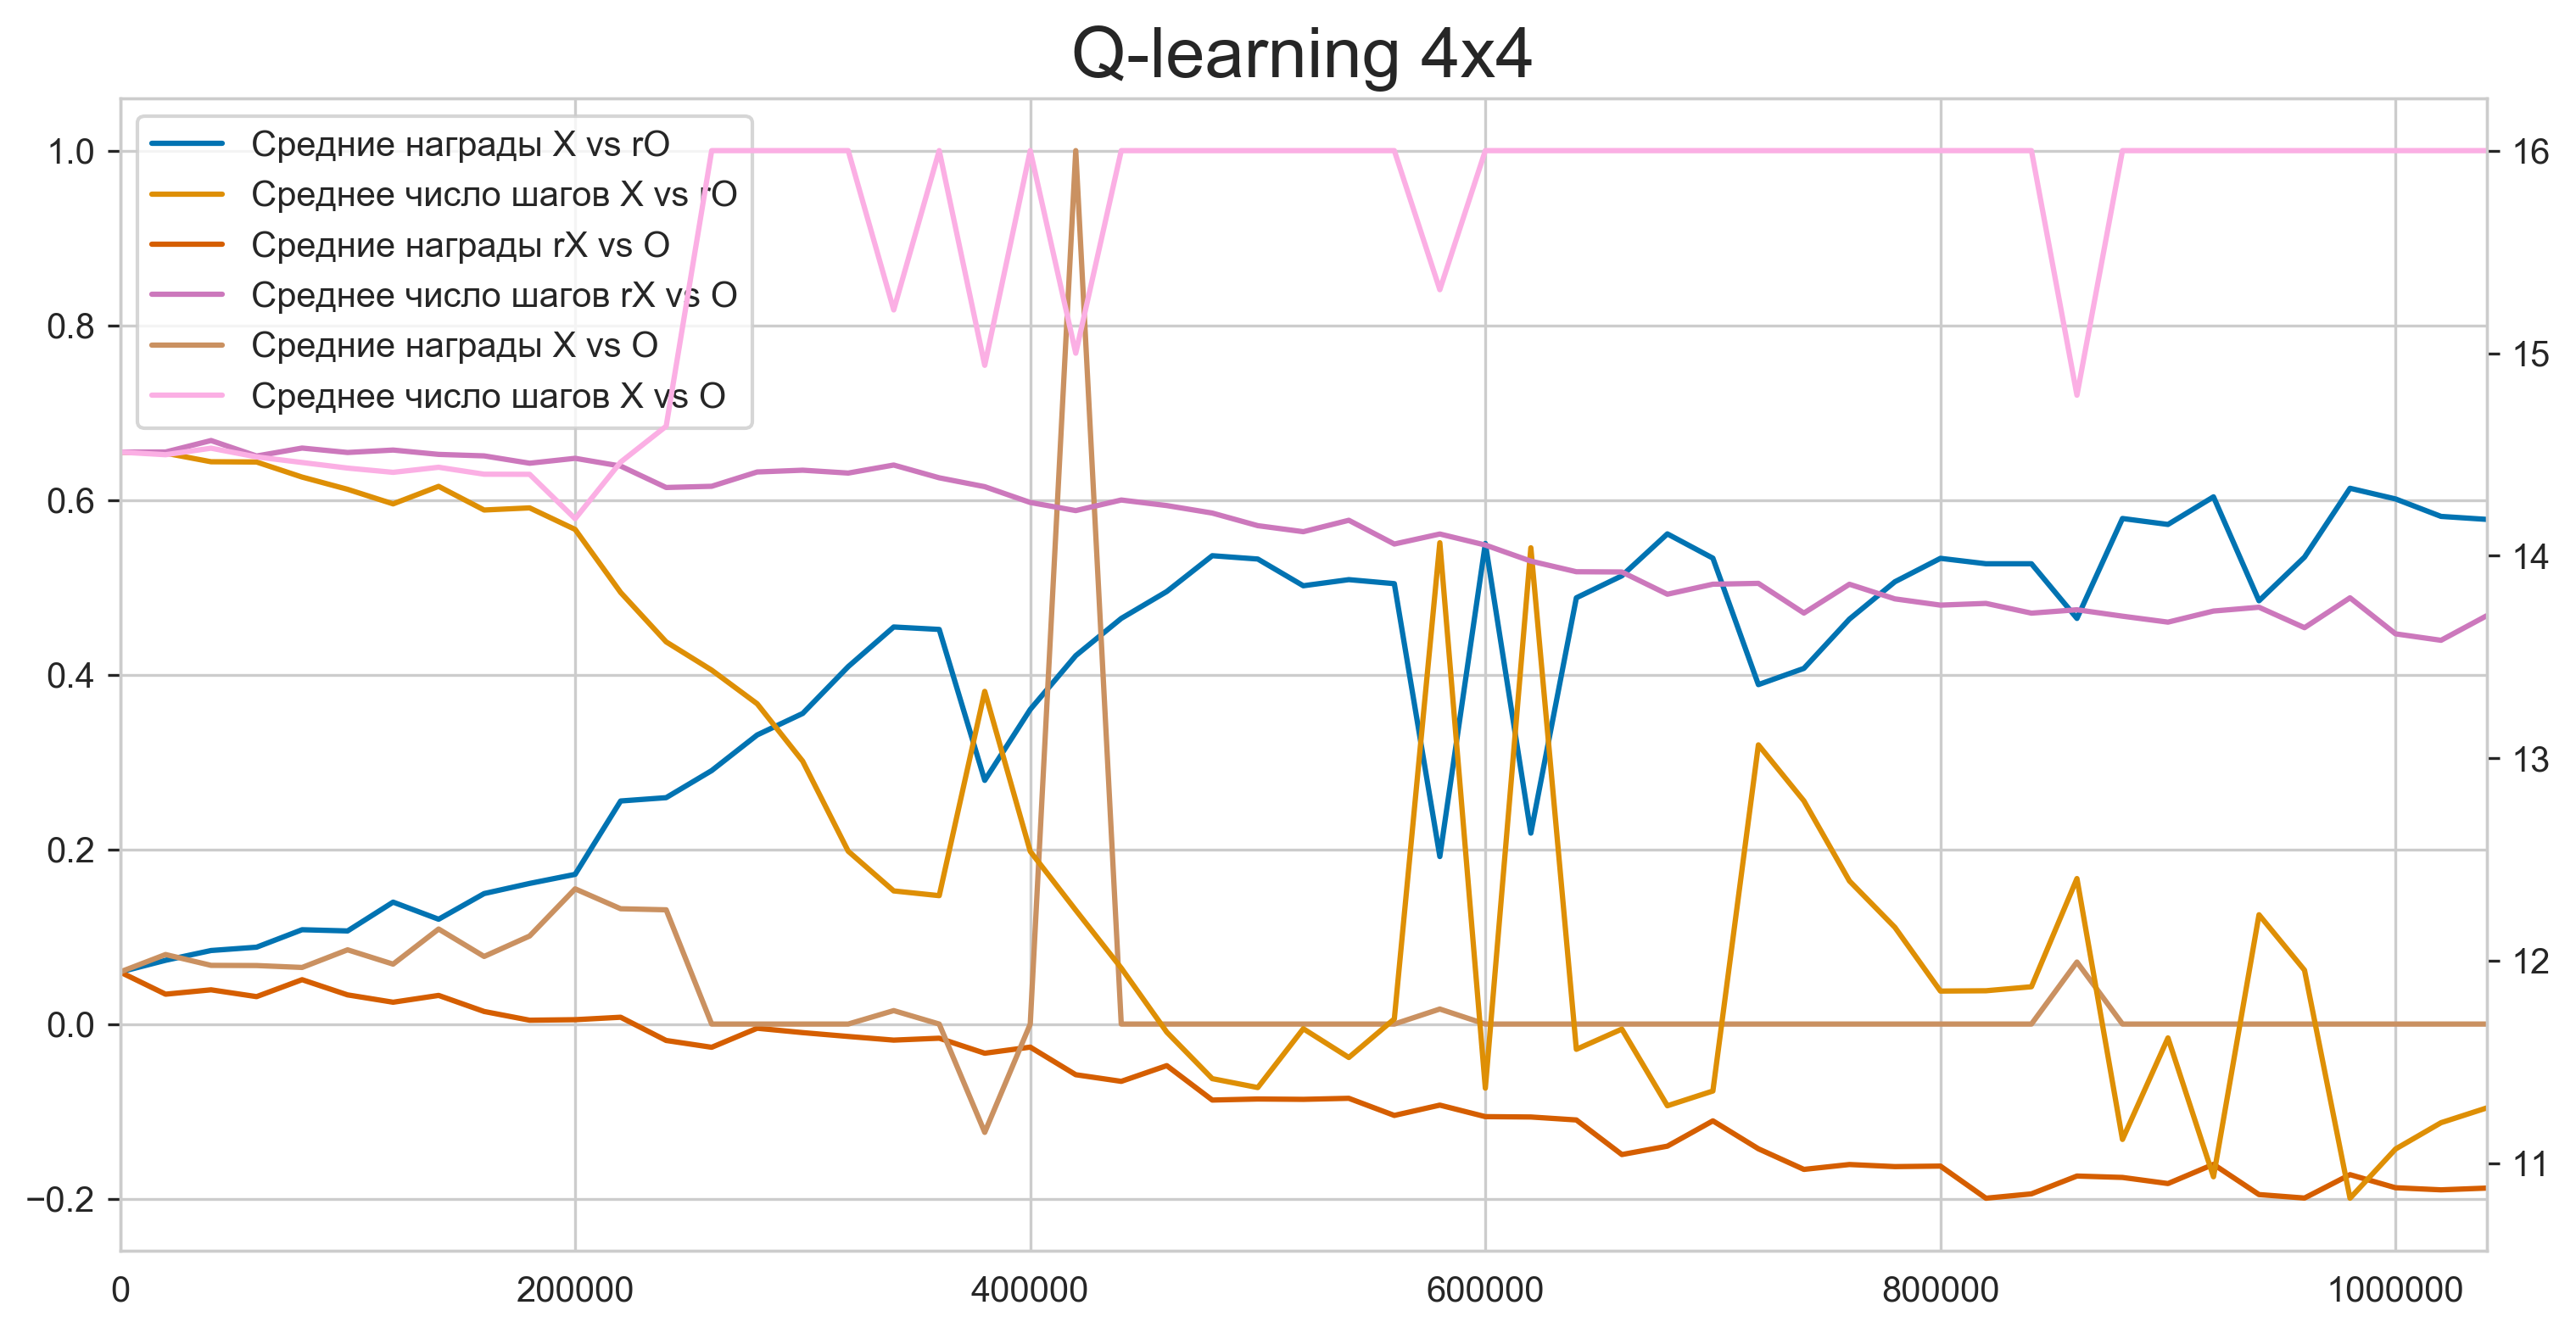

In [135]:
title = "Q-learning 4x4"
plot_results(data, title);

Как можно заметить из графика для большего поля наблюдается аналогичная ситуация, но теперь для обучения стратегии нужно сильно больше эпизодов.

## Часть вторая: добавим нейронных сетей

Попробуем реализовать обучение с помощью dqn на нейронной сети, с количеством входов и выходов равным количеству клеток поля для игры. Для семплирования состояний будем использовать replay memory

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, exptuple):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = exptuple
        self.position = (self.position + 1) % self.capacity
       
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [7]:
class Network(nn.Module):
    def __init__(self, n_rows, n_cols, layer_size=256):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(n_rows * n_cols, layer_size)
        self.l2 = nn.Linear(layer_size, n_rows * n_cols)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x

In [66]:
class TTT_DQN():
    def __init__(self, n_rows, n_cols, n_win):
        self.env = TicTacToe(n_rows, n_cols, n_win)
        self.model = Network(n_rows, n_cols)
        self.memory = ReplayMemory(10000)
        self.optimizer = optim.Adam(self.model.parameters(), 0.001)
        self.steps_done = 0
        self.episode_durations = []
        self.episode_rewards = []
        
        self.gamma = 1
        self.batch_size = 64
        
        self.eps_init, self.eps_final, self.eps_decay = 0.9, 0.05, 200
        self.num_step = 0

    def hash_to_tensor(self, state_hash):
        state = list(map(int, state_hash))
        state_tensor = torch.tensor(state, dtype=torch.float32)
        return state_tensor

    def select_greedy_action(self, state_tensor, cur_turn): 
        # print("greedy")   
        with torch.no_grad():
            predict = self.model(state_tensor).data.max(0)[1].view(1, 1)
        return predict

    def select_action(self, state_tensor, available_actions, cur_turn):
        sample = random.random()
        self.num_step += 1
        eps_threshold = self.eps_final + (self.eps_init - self.eps_final) * np.exp(-1. * self.num_step / self.eps_decay)
        if sample > eps_threshold:
            predict = self.select_greedy_action(state_tensor, cur_turn)
        else:
            # print("random")   
            with torch.no_grad():
                action = available_actions[np.random.choice(len(available_actions))]
                action_ind = self.env.int_from_action(action)
                predict = torch.tensor([[action_ind]], dtype=torch.int64)
        return predict   

    def run_episode(self, e=0, do_learning=True, greedy=False, render=False):
        self.env.reset()
        num_step = 0
        state_hash, available_actions, cur_turn = self.env.getState()

        while True:
            state_tensor = self.hash_to_tensor(state_hash)

            if greedy:
                action = self.select_greedy_action(state_tensor, cur_turn)
            else:
                action = self.select_action(state_tensor, available_actions, cur_turn)
            
            next_state, reward, done, _ = self.env.step(self.env.action_from_int(action.numpy()[0][0]))

            if render:
                self.env.render()

            next_state_tensor = self.hash_to_tensor(next_state[0])

            transition = (state_tensor, action, next_state_tensor, torch.tensor([reward], dtype=torch.float32))
            self.memory.store(transition)

            if do_learning:
                self.learn()

            state_hash, available_actions, cur_turn = next_state
            num_step += 1

            if done:
                # print("episode %d finished after %d steps" % (e, num_step))
                self.episode_durations.append(num_step)
                self.episode_rewards.append(reward)       
                break

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # берём мини-батч из памяти
        transitions = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

        batch_state = Variable(torch.cat(batch_state).reshape(self.batch_size, self.model.l1.in_features))
        batch_action = Variable(torch.cat(batch_action))
        batch_next_state = Variable(torch.cat(batch_next_state).reshape(self.batch_size, self.model.l1.in_features))
        batch_reward = Variable(torch.cat(batch_reward))

        # считаем значения функции Q
        Q = self.model(batch_state).gather(1, batch_action).reshape([self.batch_size])

        # оцениваем ожидаемые значения после этого действия
        Qmax = self.model(batch_next_state).detach().max(1)[0]
        Qnext = batch_reward + (self.gamma * Qmax)

        # и хотим, чтобы Q было похоже на Qnext - это и есть суть Q-обучения
        loss = F.smooth_l1_loss(Q, Qnext)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [71]:
dqn = TTT_DQN(3, 3, 3)
N = 1000000
print(f"Starting training for {N} episodes...")
start_time = datetime.now()

for e in range(N):
    dqn.run_episode(e, render=False)

end_time = datetime.now()

print("done after %s seconds!" % ((end_time - start_time).seconds))

Starting training for 300 episodes...
done after 8415 seconds!


С помощью такого подхода не удалось узнать что-то новое и добится результатов лучше, чем в первой части, однако dqn лучше масштабируется для больших досок